In [77]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

# Failure Mode Analysis - Downhole Well Failure Detection.

Author: Chris Hui
    
Date: 20.01.2018
    
Version 1.2

## Purpose: 

With the ongoing volatility in the energy markets, achieving competitive economics is a must. The company which is able to be a low cost energy producer in a volatile economy is the company which will survive. Our client is one of the leading energy producers in Australia with a market cap > $16bn AUD.

With the aim to be one of the leading low-cost energy producers on a global basis, attention has shifted towards the use of machine learning algorithms to help optimise failure mode detection and reduce our clients cost base. In this case, the failure
mode we are interested in will be referred to as Downhole Well Failure Mode #1 which is also associated with a Torque-up event.

Our criteria for success is a machine learning model that can detect the associated failure mode and assist operators with detecting abnormalities via a probability score output at every time stamp. 

With a reduction in operator head-count, labelling and detecting particular failures has become particularly time consuming.
Many of these judgement calls are based on experience - with many operators approaching retirement age, this experience will need to be replicated via the use of a ML algorithm. If we are able to create such an algorithm, then operators can use this
as a tool to help them with labelling their data rather than just rely on experience. 


## Major Libraries required
                                                       
* numpy - Used for array transformations.                          
* seaborn - This is our visualisation package which will allow us to create aesthetically pleasing plots.   
* pandas - We have used pandas as our primary way of manipulating and storing the data we have extracted.   
* matplotlib - This is the default plotting engine that we have used for our basic plots.                  

In [3]:
import matplotlib as mpl
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as md
from matplotlib.ticker import MultipleLocator
import seaborn as sbn
import pandas as pd
%matplotlib inline
mpl.rcParams['figure.figsize'] = (8,8)
import warnings
warnings.filterwarnings("ignore")

In [7]:
df = pd.read_csv('failureMode.csv')
df = df.drop(['Unnamed: 0'], axis=1)
#Convert Yes/No to binary classification
df['FailureMode'] = df.FailureMode.map(dict(Yes=1,No=0))


In [8]:
#Defintion of a function to loop through every variable in the dataframe and apply a .fillna to this
dtypeCount =[df.iloc[:,i].apply(type).value_counts() for i in range(df.shape[1])]

In [9]:
#Visualise the dataframe and identify when the event has occured (We may need to filter to a specific well)
df = df.apply(lambda x: x.fillna(0))
df.reset_index(inplace=True)
df['Time'] = pd.to_datetime(df['Time'], format="%d-%m-%Y %H:%M:%S", infer_datetime_format=True )
df.set_index('Time', inplace=True)

Visualising the entire time series will become very messy due to the granularity of our data.

Let us first look at a specific time period where a failure has occurred and look at the harmonics  of our signals.

The period we will look at is 2017-06-12 17:00:00 to 2017-06-12 20:00


# Hypothesis

1. Is there a discernible harmonic signal which corresponds to the failure mode?

2. Are there specific correlations which co-incide with the failure mode?

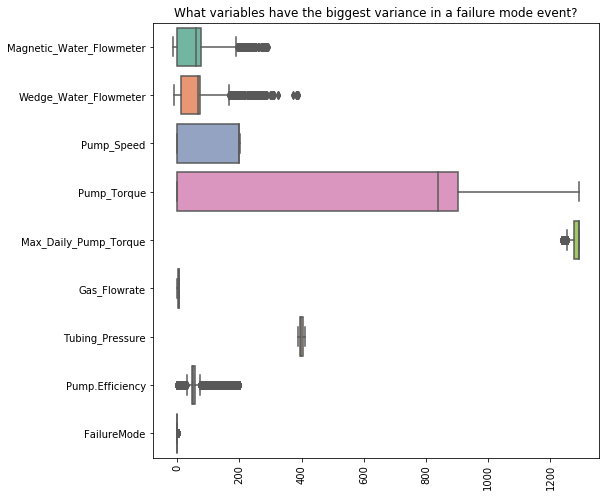

In [10]:
mpl.rcParams['figure.figsize'] = (8,8)
df_subset= df[(df.index>="2017-06-12 17:00:00")&(df.index<="2017-06-12 20:00:00")]
df_subset.drop(['index', 'Wedge_Water_Flowmeter_SD','Magnetic_Water_Flowmeter_SD','Torque_SD','Torque_Wedge_Corr'], axis=1, inplace=True)
sbn.boxplot(data=df_subset, orient='h', palette='Set2')
plt.xticks(rotation=90)
plt.title("What variables have the biggest variance in a failure mode event?")

plt.show()


Interesting - with this in mind, it seems that the following features have the most variance:
    1. Pump Torque
    2. Pump Speed
    3. Magnetic Water Flow meter
    4. Wedge Water Flow meter
    
## With this in mind, how do these variables correlate with respect to a failure mode event?

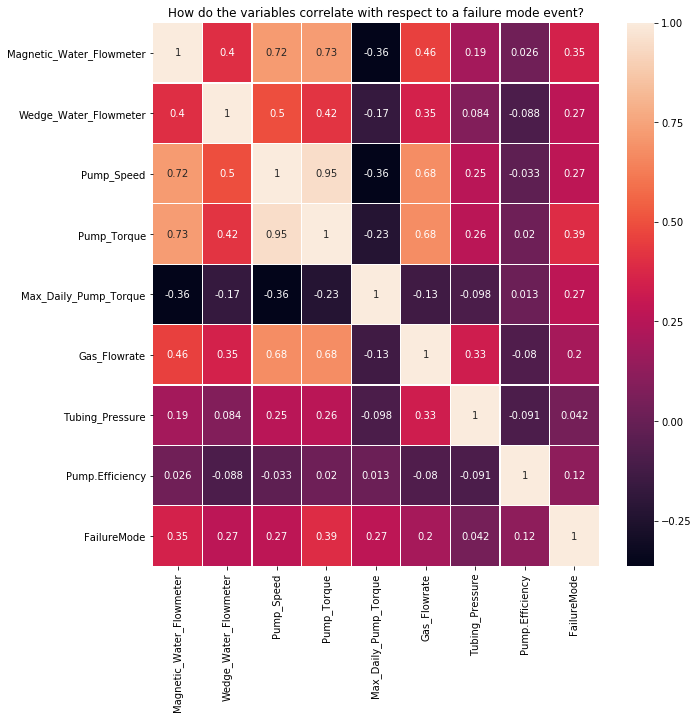

In [11]:
corr = df_subset.corr()
fig, ax = plt.subplots(figsize=(10,10)) 
sbn.heatmap(corr, annot=True,linewidths=.1,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values,
            ax=ax)
plt.title("How do the variables correlate with respect to a failure mode event?")
plt.show()


In [12]:
df_subset = df_subset[(df_subset['Pump_Torque']>=0)]
#Create another subset of the dataframe focusing on Magnetic_water_Flowmeter, Wedge_Water_Flowmeter, Pump_Speed, Pump_Torque
filt = ['Magnetic_Water_Flowmeter','Wedge_Water_Flowmeter','Pump_Speed','Pump_Torque','FailureMode']
df_subset_key_var = df_subset[filt]

In [13]:
print (df.columns)

Index(['index', 'Magnetic_Water_Flowmeter', 'Wedge_Water_Flowmeter',
       'Pump_Speed', 'Pump_Torque', 'Max_Daily_Pump_Torque', 'Gas_Flowrate',
       'Tubing_Pressure', 'Pump.Efficiency', 'Wellname',
       'Wedge_Water_Flowmeter_SD', 'Magnetic_Water_Flowmeter_SD', 'Torque_SD',
       'Torque_Wedge_Corr', 'FailureMode'],
      dtype='object')


In [14]:
#Create Rolling Subset Dataframe for 1 well
rolling_df_subset = df_subset.rolling(30).std()
rolling_df_subset = rolling_df_subset[30:]
names = rolling_df_subset.columns + "_stdev"
rolling_df_subset.columns = names 
filt = ['Magnetic_Water_Flowmeter_stdev','Wedge_Water_Flowmeter_stdev','Pump_Speed_stdev','Pump_Torque_stdev','FailureMode_stdev']
plot_rolling_df_subset = rolling_df_subset[filt]

rolling_df_subset = rolling_df_subset.drop('FailureMode_stdev', axis=1)

In [15]:
#Create Rolling Subset Dataframe for all wells
rolling_df_all = df.rolling(30).std()
rolling_df_all = rolling_df_all[30:]
names = rolling_df_all.columns + "_stdev"
rolling_df_all.columns = names 
#filt = ['ID_stdev','Magnetic_Water_Flowmeter_stdev','Wedge_Water_Flowmeter_stdev','Pump_Speed_stdev','Pump_Torque_stdev','FailureMode_stdev']
#rolling_df_subset = rolling_df_subset.drop('FailureMode_stdev', axis=1)
rolling_df_all = rolling_df_all.drop(['Wedge_Water_Flowmeter_SD_stdev', 'Magnetic_Water_Flowmeter_SD_stdev','Torque_SD_stdev', 'Torque_Wedge_Corr_stdev','FailureMode_stdev', 'index_stdev'], axis=1)

## Peculiar - the features with the most variance don't correlate too strongly to a failure mode event. Why is this?

This could be due to the level of dispersion within the data points. 
With this line of thinking, we will plot 2 plots;

1. Plot the raw features as they are with respect to a failure mode event
2. Plot the re-engineered features transformed via standard deviation spreads of (30) points

We will focus on the 4 key features which exhbit the most variance.

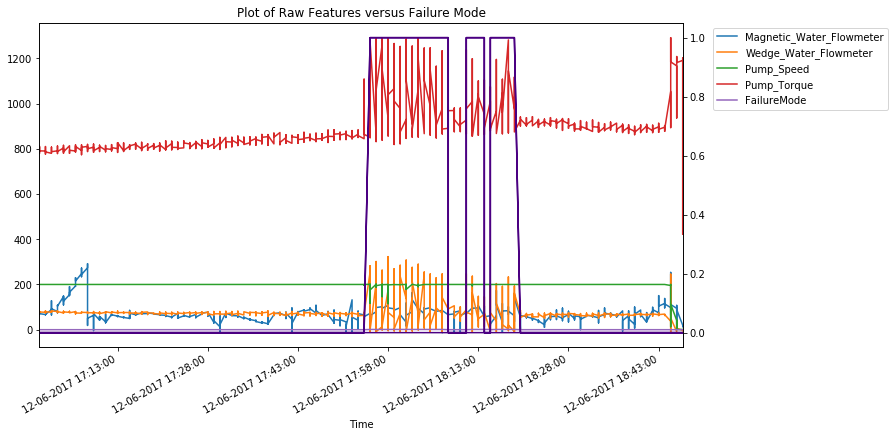

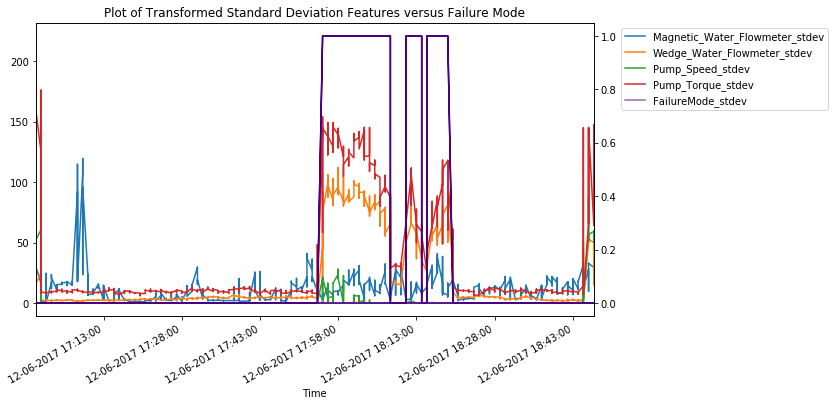

In [16]:
mpl.rcParams['figure.figsize'] = (10,6)
# f, axarr = plt.subplots(2, sharex=True)
ax = df_subset_key_var.plot()
ax2 = ax.twinx()

ax2.plot(df_subset_key_var.FailureMode, 'indigo')
xfmt = md.DateFormatter('%d-%m-%Y %H:%M:%S')
ax.xaxis.set_major_formatter(xfmt)
ax.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.tight_layout()
plt.title('Plot of Raw Features versus Failure Mode')
plt.show()

#Create Rolling DF 
mpl.rcParams['figure.figsize'] = (10,6)
ax = plot_rolling_df_subset.plot()
ax2=ax.twinx()
ax2.plot(df_subset_key_var.FailureMode, 'indigo')
ax.legend(bbox_to_anchor=(1.04,1), loc="upper left")
xfmt = md.DateFormatter('%d-%m-%Y %H:%M:%S')
ax.xaxis.set_major_formatter(xfmt)
plt.title('Plot of Transformed Standard Deviation Features versus Failure Mode')
plt.show()

#### We note that the spread between Pump Torque and Wedge Water Flow is much more pronounced than previously thought. (!)
#### Let's confirm this with a heat-map view and see if the correlation scores improve if we use the rolling features rather than the standard.


In [17]:
filt = ['FailureMode','Pump_Speed']
event_df = df[filt]
event_df = event_df.drop(['Pump_Speed'], axis=1)
event_df = event_df[30:]

In [18]:
rolling_df_all['FailureMode'] = event_df['FailureMode']

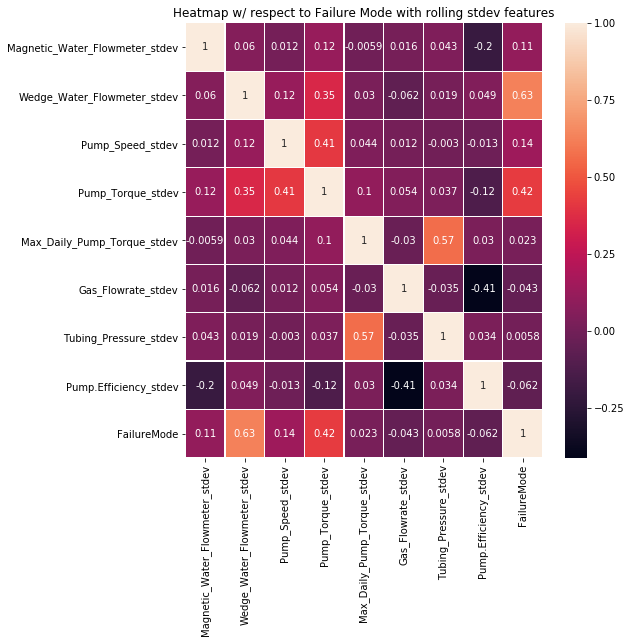

In [19]:
#Using the dataframe df, we will create a new rolling set of features with respect to 1 well
#We need to rejoin a new data frame with when the '1' events have occurred to our current dataframe
corr = rolling_df_all.corr()
fig, ax = plt.subplots(figsize=(8,8)) 
sbn.heatmap(corr, annot=True,linewidths=.1,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values,
            ax=ax)
plt.title("Heatmap w/ respect to Failure Mode with rolling stdev features")
plt.show()


#### With the latest heatmap incorporating standard deviated features, we can clearly see the two features which highlight the most variance. 

This is shown to be:

1) Wedge Water Flowmeter and 

2) Pump Torque

#### Using a Classification and Regression Tree (CART) - we'll verify whether how significant these features actually are.

In [21]:
print (rolling_df_all.columns)

Index(['Magnetic_Water_Flowmeter_stdev', 'Wedge_Water_Flowmeter_stdev',
       'Pump_Speed_stdev', 'Pump_Torque_stdev', 'Max_Daily_Pump_Torque_stdev',
       'Gas_Flowrate_stdev', 'Tubing_Pressure_stdev', 'Pump.Efficiency_stdev',
       'Wellname_stdev', 'FailureMode'],
      dtype='object')


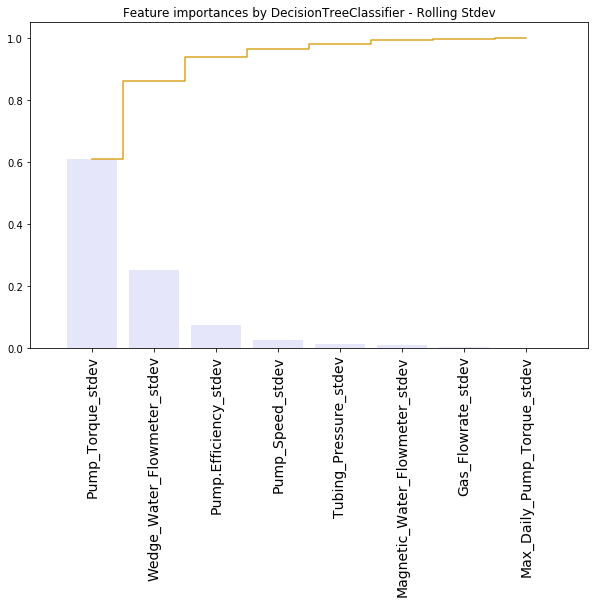

In [22]:
# #Decision Tree Classifier Model
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale

# Create train and test splits
variables = rolling_df_all.drop(['FailureMode','Wellname_stdev'],axis=1)
X = variables
y = rolling_df_all['FailureMode']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25, random_state=42, stratify=y)

dtree = tree.DecisionTreeClassifier(
    max_depth=15
    )
dtree = dtree.fit(X_train,y_train)

#plot the importances in a cumulative scale approaching 1
importances = dtree.feature_importances_
feat_names = X.columns

indices = np.argsort(importances)[::-1]
plt.figure(figsize=(10,6))
plt.title("Feature importances by DecisionTreeClassifier - Rolling Stdev")
plt.bar(range(len(indices)), importances[indices], color='Lavender',  align="center")
plt.step(range(len(indices)), np.cumsum(importances[indices]), where='mid', label='Cumulative',color='goldenrod')
plt.xticks(range(len(indices)), feat_names[indices], rotation='vertical',fontsize=14)
plt.xlim([-1, len(indices)])
plt.show()

#### Using the CART, our initial suspicions regarding Pump Torque and Wedge Water Flow have been validated.

Taking this into account, we will use these two variables as features in an equation to output a conditional probability.

This will be done via the logistic regression equation highlighted below:

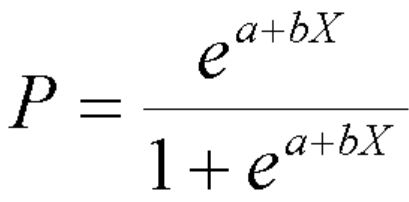


This produces a conditional probability of event X occuring with respect to a series of logistic inputs. 
The conditional probability is bounded between the ranges 0 to 100 in real terms.

This following symbols are noted as such:

    * P - Probabilistic score bounded 0 - 1
    * e - natural logarithm
    * a + bx - logistic input result

You might have wondered why we opted to use Logistic Regression (Sigmoid Function) over random forest implementations or gradient boosted algorithms.

This is because, logistic regression was shown to have a very high score, but more importantly, we can clearly explain the underlying mathematics to our technical audience. With trees - it is very difficult to trace the result back.

As the audience needs to be convinced behind the mathematical robustness before it is adopted, this is a critical consideration.


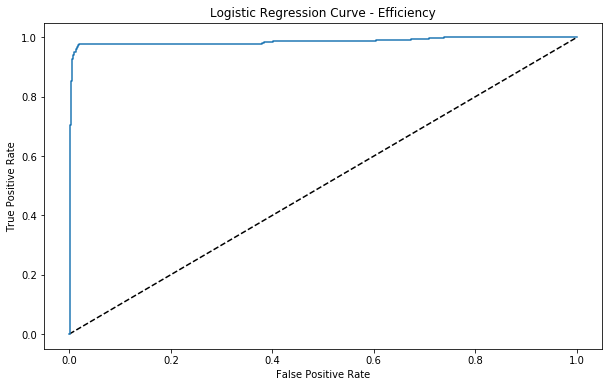

[[32463    67]
 [  114   266]]
             precision    recall  f1-score   support

          0       1.00      1.00      1.00     32530
          1       0.80      0.70      0.75       380

avg / total       0.99      0.99      0.99     32910

logreg score is:0.99450015193
AUC is:0.986512126458
10-fold CV score is:[ 0.9848082   0.99878456  0.99665755  0.99711334  0.99164388  0.99597387
  0.9987085   0.99946821  0.98807263  0.98769278]


In [24]:
#Logistic Regression Model
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn.preprocessing import scale
variables = rolling_df_all.drop(['FailureMode','Wellname_stdev'],axis=1)
X = scale(variables)
y = rolling_df_all['FailureMode']

#instantiate logistic regression object
logreg = LogisticRegression()
#Create 4 variables to handle the training data and test data
X_train, X_test, y_train,y_test = train_test_split(X,y, test_size=0.25, random_state=21, stratify=y)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

y_pred_prob = logreg.predict_proba(X_test)[:,1]
fpr, tpr, threshold = roc_curve(y_test, y_pred_prob)
plt.plot([0,1],[0,1],'k--')
plt.plot(fpr, tpr, label='Logistic Regression on Efficiency')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression Curve - Efficiency')
plt.show()

logic_AUC = roc_auc_score(y_test, y_pred_prob)
cv_results = cross_val_score(logreg, X,y, cv=10)
print (confusion_matrix(y_test, y_pred))
print (classification_report(y_test,y_pred))
print ("logreg score is:" + str(logreg.score(X_test,y_test)))
print ("AUC is:" + str(logic_AUC))
print ("10-fold CV score is:" + str(cv_results))



In [25]:
#Logistic Regression Model Approach
import statsmodels.api as sm
import numpy as np

predictors = ['Pump_Torque_stdev','Wedge_Water_Flowmeter_stdev', 'FailureMode']
logisticRegVariables = rolling_df_all[predictors]
logisticRegVariables['intercept'] = 1

X = logisticRegVariables.drop(['FailureMode'], axis=1)
y = logisticRegVariables['FailureMode']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25, random_state=111, stratify=y)

In [26]:
predictors = ['Pump_Torque_stdev','Wedge_Water_Flowmeter_stdev', 'intercept']
logReg = sm.Logit(y_train, X_train[predictors])
answer = logReg.fit()
log_coef = answer.params

print (log_coef)

Optimization terminated successfully.
         Current function value: 0.021592
         Iterations 10
Pump_Torque_stdev              0.011264
Wedge_Water_Flowmeter_stdev    0.076771
intercept                     -6.862445
dtype: float64


#### Now with the co-efficients available, we can plug this into an equation of the form:
#### P(X w.r.t PumpTorqueStdev & WedgeWaterFlowMeter) = Beta 0 (intercept) + Beta 1 x Value 1 + Beta 2 x Value 2
#### This equation will then return a value unbounded by real constraints; in other words, this is our logistic odds.
#### Next to complete the sigmoid function we need to take our logistic odds and remove the 'log' effect through applying an exponential function and proceeding with: 1 / (1 + exponent(logistic input) *-1)

In [27]:
probability_df = rolling_df_all
probability_df['prediction'] = (log_coef[0]*probability_df['Pump_Torque_stdev'] + log_coef[1]*probability_df['Wedge_Water_Flowmeter_stdev'] +log_coef[2])
probability_df['FailureModeProbability'] = (1 / (1 + np.exp(probability_df['prediction']*-1)))


#### Now that we have the probablistic outputs, it's important we see how it fits against the actual data.


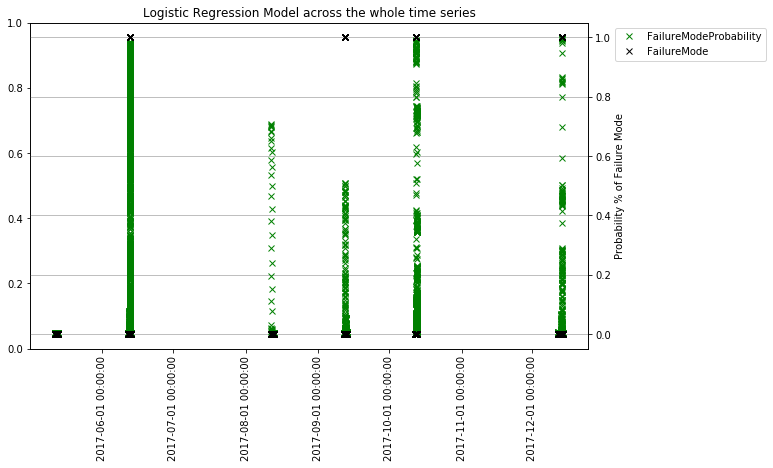

In [28]:
fig, ax = plt.subplots()
plt.xticks(rotation=90)
ax = ax.twinx()

ax.plot(probability_df.index, probability_df.FailureModeProbability, 'gx')
ax.plot(probability_df.index, probability_df.FailureMode, 'kx')
ax.grid()
plt.legend()
xfmt = md.DateFormatter('%Y-%m-%d %H:%M:%S')
ax.xaxis.set_major_formatter(xfmt)
locator = md.MinuteLocator(byminute=20)
ax.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.xlabel('Observations')
plt.ylabel('Probability % of Failure Mode')
plt.title("Logistic Regression Model across the whole time series")
plt.show()

#### Great. For every time a 'failure' has occurred, our failure model is clearly detecting / predicting this with a score for every time stamp.

#### However, the time scale is too zoomed out.

#### Let's zoom into one specific time window from 2017-06-12 17:00 to 2017-06-12 20:00:00 where the first failure event has occurred.

#### The first plot will be that of the rolling standard deviated features plotted against failures.

#### The second plot will be that of the probablistic model against the labelled failures.

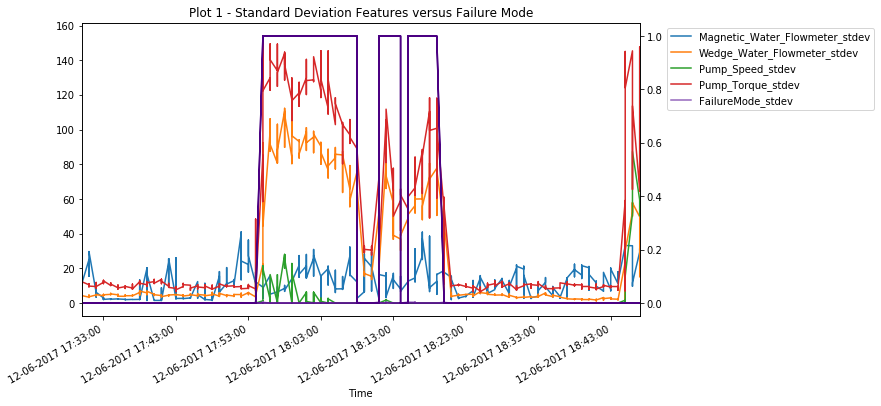

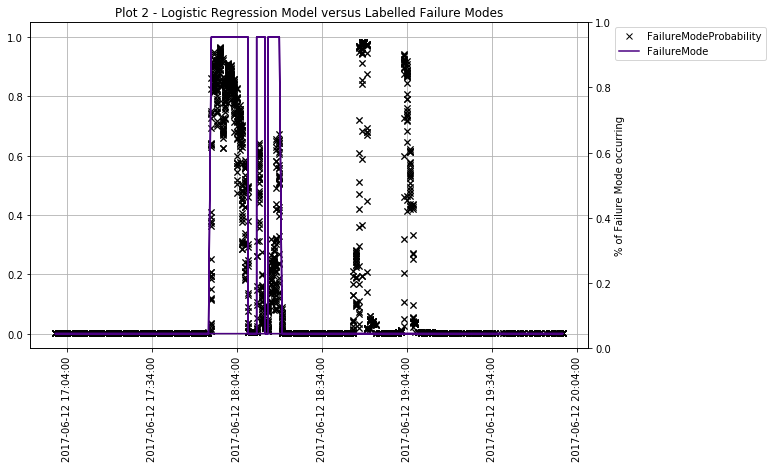

In [29]:
mpl.rcParams['figure.figsize'] = (10,6)
plot_rolling_df_subset = plot_rolling_df_subset[(plot_rolling_df_subset.index>="2017-06-12 17:30:00")&(plot_rolling_df_subset.index<="2017-06-12 20:00:00")]
ax = plot_rolling_df_subset.plot()
ax2=ax.twinx()
ax2.plot(df_subset_key_var.FailureMode, 'indigo')
ax.legend(bbox_to_anchor=(1.04,1), loc="upper left")
xfmt = md.DateFormatter('%d-%m-%Y %H:%M:%S')
ax2.xaxis.set_major_formatter(xfmt)
plt.title('Plot 1 - Standard Deviation Features versus Failure Mode')
plt.show()

model_test = probability_df[(probability_df.index>="2017-06-12 17:00:00")&(probability_df.index<="2017-06-12 20:00:00")]

fig, ax = plt.subplots()
plt.xticks(rotation=90)
ax2 = ax.twinx()

ax.plot(model_test.index, model_test.FailureModeProbability, 'kx')
ax.plot(model_test.index, model_test.FailureMode, 'indigo')
ax.grid()
plt.legend()
xfmt = md.DateFormatter('%Y-%m-%d %H:%M:%S')
ax.xaxis.set_major_formatter(xfmt)
locator = md.MinuteLocator(byminute=20)
ax.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.xlabel('Observations')
plt.ylabel('% of Failure Mode occurring')
plt.title("Plot 2 - Logistic Regression Model versus Labelled Failure Modes")
plt.show()


#### Not only was our model able to accurately detect the failure modes with an associated probablistic score corresponding to the labeled failure events.

#### Our model also identified and picked up 2 additional failure modes that were indicators of failure events that were missed by operators.

# Congratulations - we have now built a model that can accurately detect and assist operators with identification of a particular failure mode, just as accurately as the human operators!